In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


In [3]:
def imshow(img):
    plt.axis("off")
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.show()
    

In [4]:
class DetectionError(Exception):
    pass

In [5]:
RED_BGR = (0,0,255)
YELLOW_BGR = (0,255,255)
GREEN_BGR = (0,255,0)
BLUE_BGR = (255,0,0)

In [6]:
def create_tracker(tracker_type):
    tracker_types = [
        "BOOSTING",
        "MIL",
        "KCF",
        "TLD",
        "MEDIANFLOW",
        "MOSSE",
        "CSRT",
    ]
    if tracker_type == 'BOOSTING':
        tracker = cv2.legacy.TrackerBoosting_create()
    if tracker_type == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_type == 'TLD':
        tracker = cv2.legacy.TrackerTLD_create()
    if tracker_type == 'MEDIANFLOW':
        tracker = cv2.legacy.TrackerMedianFlow_create()
    if tracker_type == 'MOSSE':
        tracker = cv2.legacy.TrackerMOSSE_create()
    if tracker_type == "CSRT":
        tracker = cv2.TrackerCSRT_create()
    return tracker

def draw_bbox(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)

In [7]:
cap = cv2.VideoCapture("./videos/gameplay_phone_clip.mp4")
if not cap.isOpened():
    raise Exception("Could not open")


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width, frame_height)

fps = cap.get(cv2.CAP_PROP_FPS)
fps

1920 1080


29.661252107835814

4207.320848584175
4204.977702736855


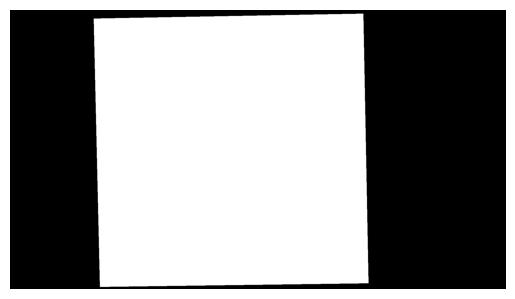

In [8]:
# calculating boardmask
def get_board_mask(frame):
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    edges = cv2.Canny(blurred,100,100)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = []
    for contour in contours:
        arc_length = cv2.arcLength(contour, True) 
        if arc_length < 1000:
            continue
            
        approx = cv2.approxPolyDP(contour, 0.02 * arc_length ,True)
        if len(approx) == 4:
            print(cv2.arcLength(contour, True))
            rectangles.append(approx)
            
    # assert len(rectangles) == 1
    rectangle = rectangles[0] #CHEAP HACK
    board_mask =  cv2.drawContours(np.zeros_like(edges), [rectangle], -1, (255,0,0), -1)
    return np.dstack([board_mask, board_mask, board_mask])

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
board_mask = get_board_mask(frame)
imshow(board_mask)


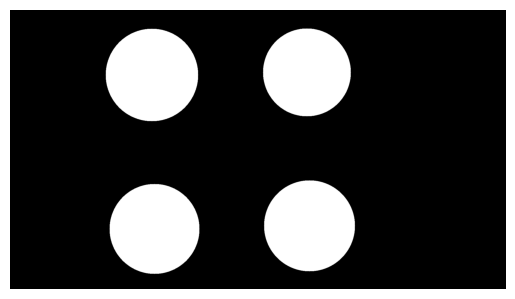

In [9]:

def get_home_masks(frame_gray):
    assert len(frame_gray.shape) == 2, "frame must be gray"
    
    circles = cv2.HoughCircles(
        frame_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 2,
        # TODO: HOME IS CIRCLE IN CIRCLE -> make minDist small, find center pairs which are very close
        # and delete the smaller
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 100,
        param2=100,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.5),
    )

    # TODO: IT DOESNT DETECT IT YET IT ASSIGNS RANDOMLY!!! 
    yellow_home = np.zeros(frame_gray.shape + (3,) , dtype=np.uint8)
    red_home = np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
    green_home = np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
    blue_home = np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
    
    homes = dict(
                 red = dict(center = None, radius = None, mask=red_home),      
                 blue = dict(center = None, radius = None, mask=blue_home),
                 green = dict(center = None, radius = None, mask=green_home),
                 yellow = dict(center = None, radius = None, mask=yellow_home),
        
                )
                 
                 
        
    circles = np.uint16(np.around(circles))
    assert circles.shape[1] == 4, f"Found not 4 homes, but {circles.shape[1]}"
    for (i, color) in zip(circles[0,:], homes):
        # Radius is increased
        homes[color]["center"] = (i[0],i[1])
        homes[color]["radius"] = i[2]
        cv2.circle(homes[color]["mask"] ,(i[0],i[1]),int(1.1*i[2]),(255,255,255),-1)

    return homes

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
frame = np.where(board_mask, frame, 0)
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
homes = get_home_masks(frame_gray)
all_homes_mask = homes["red"]["mask"] | homes ["blue"]["mask"] | homes["yellow"]["mask"] | homes["green"]["mask"]
imshow(all_homes_mask)

In [10]:
# cap.set(cv2.CAP_PROP_POS_FRAMES,0)
# ret, frame = cap.read()
# frame = frame & board_mask & ~all_homes_mask
# frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# lower_red1 = np.array([0, 120, 70])
# upper_red1 = np.array([10, 255, 255])
# lower_red2 = np.array([170, 120, 70])
# upper_red2 = np.array([180, 255, 255])
# mask1 = cv2.inRange(frame_hsv, lower_red1, upper_red1)
# mask2 = cv2.inRange(frame_hsv, lower_red2, upper_red2)
# red_mask = cv2.bitwise_or(mask1, mask2)
# red_mask = np.dstack([red_mask, red_mask, red_mask])
# imshow(red_mask)
# # frame = cv2.cvtColor(f
# imshow(frame)

In [11]:


def get_pawn_bbox(home: dict):
    my_home_center = home["center"]
    my_home_radius = home["radius"]
    
    x, y = my_home_center
    w, h = int(0.55*my_home_radius), int(0.55*my_home_radius) 
    x -= int(0.1 * my_home_radius)
    y += int(0.1 * my_home_radius)
    
    return (x-w,y,w,h)



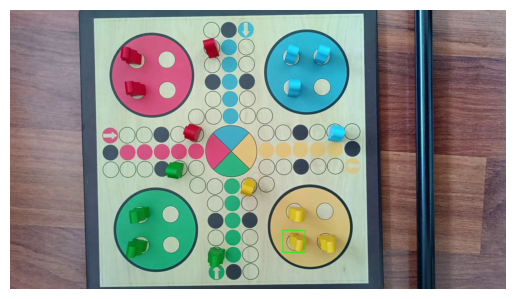

In [12]:
cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()

# frame_eq = np.zeros_like(frame)
# frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
# frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
# frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])

# blue_pawn = get_pawn_bbox(frame_eq, homes["blue"])
# red_pawn = get_pawn_bbox(frame_eq, homes["red"])
# green_pawn = get_pawn_bbox(frame_eq, homes["green"])
yellow_pawn = get_pawn_bbox(homes["yellow"])
# draw_bbox(frame, blue_pawn)
# draw_bbox(frame, red_pawn)
# draw_bbox(frame, green_pawn)
draw_bbox(frame, yellow_pawn)
yellow_pawn_tracker = create_tracker("CSRT")
yellow_pawn_tracker.init(frame, yellow_pawn)

_, frame = cap.read()
ok, bbox = yellow_pawn_tracker.update(frame)
if ok:
    draw_bbox(frame, bbox, (0, 255, 0))
imshow(frame)
# imshow(blue_pawn)
# imshow(red_pawn)
# imshow(green_pawn)
# imshow(yellow_pawn)

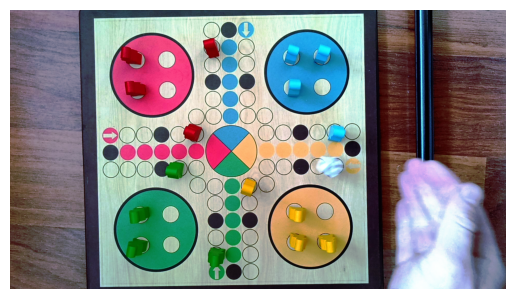

In [13]:
cap.set(cv2.CAP_PROP_POS_FRAMES,53)
ret, frame = cap.read()
frame_eq = np.zeros_like(frame)
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])
imshow(frame_eq)

# Result - weak

In [21]:
%%time
cap = cv2.VideoCapture("./videos/gameplay_phone_clip.mp4")
if not cap.isOpened():
    raise Exception("Could not open")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))


fps = cap.get(cv2.CAP_PROP_FPS)

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
video_out = cv2.VideoWriter(
    "output.avi",
    cv2.VideoWriter_fourcc(*"DIVX"),
    fps,
    (frame_width, frame_height),
)

_, frame = cap.read()
yellow_pawn = get_pawn_bbox(homes["yellow"])
yellow_pawn_tracker = create_tracker("MIL")
yellow_pawn_tracker.init(frame, yellow_pawn)

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
while cap.isOpened():
    ret, frame = cap.read()
    if frame is None:
        print(ret)
        break
    board = np.where(board_mask, frame_eq, 0)
    # sidewalk = board & ~all_homes_mask
    
    ok, bbox = yellow_pawn_tracker.update(frame)
    if ok:
        draw_bbox(frame, bbox, (0, 255, 0))
    else:
        frame = cv2.rectangle(frame,  (0,0), (100,100), RED_BGR,-1)
   
    # video_out.write(frame)
    cv2.imshow('video', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows() 
clear_output()

CPU times: user 2min 10s, sys: 15.1 s, total: 2min 25s
Wall time: 29.9 s


In [15]:
!mpv output.avi

=Failed to recognize file format.
Exiting... (Errors when loading file)
>